In [7]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [8]:
#file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
file_path = '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp'
diagType1 = 'ocean_cobalt_omip_tracers_year_z'
diagType2 = 'ocean_annual_z'

years = ['0521-0525','0526-0530']

In [9]:
plot_out='../plots_esm42/060922/esm42_dev_060922_'

In [10]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
talk_var = 'talk'
talk_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
talk_files = [dot.join([talk_file_prefix + diagType1, yy, talk_var, 'nc']) for yy in years]
print(talk_files)

so_var = 'so'
so_file_prefix = os.path.join(file_path, diagType2, 'ts', 'annual', '5yr/')
so_files = [dot.join([so_file_prefix + diagType2, yy, so_var, 'nc']) for yy in years]
print(so_files)

['/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_cobalt_omip_tracers_year_z/ts/annual/5yr/ocean_cobalt_omip_tracers_year_z.0521-0525.talk.nc', '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_cobalt_omip_tracers_year_z/ts/annual/5yr/ocean_cobalt_omip_tracers_year_z.0526-0530.talk.nc']
['/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0521-0525.so.nc', '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0526-0530.so.nc']


In [11]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

## Total Alkalinity

In [12]:
# Model
ds_talk = xr.open_mfdataset(talk_files, combine='by_coords')
ds_talk = ds_talk.sel(z_l=2.5)
# convert from mol m-3 to mmoles m-3
ds_talk['talk'].values = ds_talk['talk'].values*1000
ds_talk.talk.attrs['units'] = 'mmol m-3'

In [13]:
# Observations
# Alkalinity data, remapped from GLODAP 
# units are micromoles per kg, convert to mmoles m^3 using 1035/1000
alk_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/TAlk_glodap_esm4grid.nc'
alk_obs = xr.open_dataset(alk_obs_file)
alk_obs = alk_obs.sel(z_l=2.5)
alk_obs['TAlk_glodap'].values = alk_obs['TAlk_glodap'].values * 1035./1000.

## Surface salinity

In [14]:
# Model
ds_so = xr.open_mfdataset(so_files, combine='by_coords')
ds_so = ds_so.sel(z_l=2.5)

In [15]:
# Observations
# Salinity data, remapped from GLODAP 
# units are micromoles per kg, convert to mmoles m^3 using 1035/1000
salt_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/Salt_glodap_esm4grid.nc'
salt_obs = xr.open_dataset(salt_obs_file)
salt_obs = salt_obs.sel(z_l=2.5)
salt_obs

<xarray.Dataset>
Dimensions:      (xh: 720, yh: 576)
Coordinates:
    z_l          float64 2.5
  * yh           (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * xh           (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
Data variables:
    Salt_glodap  (yh, xh) float64 ...

# Compute 

## Salinity normalized alkalinity (using 35 psu)

In [16]:
ds_talk['sAlk'] = 35.0*ds_talk['talk']/ds_so['so']

In [17]:
ds_talk = ds_talk.mean(dim='time')

In [18]:
alk_obs['sAlk'] = 35.0*alk_obs['TAlk_glodap']/salt_obs['Salt_glodap']

# Evaluate Skill Metrics

In [19]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [20]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [21]:
X=ds_talk.talk.stack(z=('xh','yh')).values
Y=alk_obs.TAlk_glodap.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_alk = X[mask] - Y[mask]
res2_alk = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_alk = stats.skew(res1_alk)
skew2_alk = stats.skew(res2_alk)
res_alk = res1_alk
r_alk = stats.pearsonr(X[mask],Y[mask])[0]
rmse_alk = rmse_diffs(res_alk)
bias_alk = np.mean(res_alk)

In [22]:
X=ds_talk.sAlk.stack(z=('xh','yh')).values
Y=alk_obs.sAlk.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_salk = X[mask] - Y[mask]
res2_salk = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_salk = stats.skew(res1_salk)
skew2_salk = stats.skew(res2_salk)
res_salk = res1_salk
r_salk = stats.pearsonr(X[mask],Y[mask])[0]
rmse_salk = rmse_diffs(res_salk)
bias_salk = np.mean(res_salk)

In [23]:
ds_so.so

<xarray.DataArray 'so' (time: 10, yh: 576, xh: 720)>
dask.array<getitem, shape=(10, 576, 720), dtype=float32, chunksize=(5, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0521-07-02 12:00:00 ... 0530-07-02 12:00:00
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    z_l      float64 2.5
Attributes:
    units:          psu
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

# Plot 

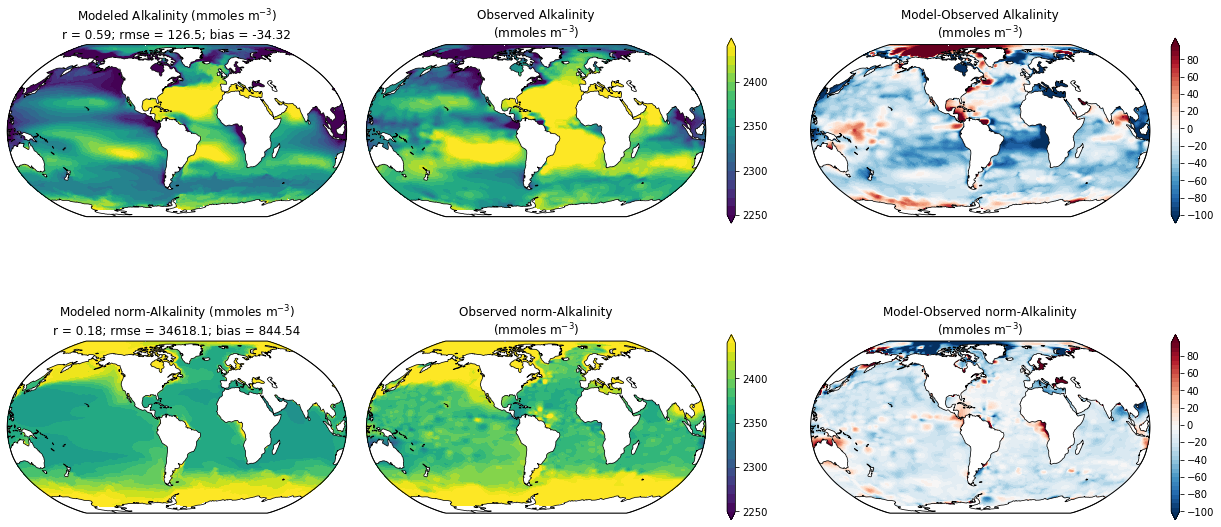

In [24]:
fig=plt.figure(figsize=(22,10))
gs=gridspec.GridSpec(2,3, wspace=0.05, width_ratios=[1,1.25,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Alkalinity                                                              #
###########################################################################

cmin = 2250; cmax = 2450; cint = 10
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field1=ds_talk.talk
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field1, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled Alkalinity (mmoles m$^{-3}$)\nr = ' + str(np.round(r_alk,2)) + \
                 '; rmse = ' + str(np.round(rmse_alk,1)) + \
                 '; bias = ' + str(np.round(bias_alk,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field2=alk_obs.TAlk_glodap
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field2, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Alkalinity\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[2250,2300,2350,2400,2450], shrink=0.75)

i=2
ax[i]=plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=300.0))
field=field1-field2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(-100,100,5), cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Model-Observed Alkalinity\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)

###########################################################################
# Salinity-normalized Alkalinity                                          #
###########################################################################

cmin = 2250; cmax = 2450; cint = 10
levels=np.arange(cmin,cmax,cint)

i=3
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field1=ds_talk.sAlk
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field1, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled norm-Alkalinity (mmoles m$^{-3}$)\nr = ' + str(np.round(r_salk,2)) + \
                 '; rmse = ' + str(np.round(rmse_salk,1)) + \
                 '; bias = ' + str(np.round(bias_salk,2)), fontsize=fs)

i=4
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field2=alk_obs.sAlk
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field2, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed norm-Alkalinity\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[2250,2300,2350,2400,2450], shrink=0.75)

i=5
ax[i]=plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=300.0))
field=field1-field2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(-100,100,5), cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Model-Observed norm-Alkalinity\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)


plt.tight_layout()
fname = 'sfc_salk_diffs'
plt.savefig(plot_out+fname+'.png', dpi=300, bbox_inches='tight')